In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Loading Data Set 1: GDSC 

Please note that before running the code, you will need all the GDSC files. They can be found on the drive (https://drive.google.com/drive/u/1/folders/11omvpOttkdZZgv_ppbtcCbojkuVR-D61) or directly on the GDSC website.

In [4]:
NB_DRUGS = 10 #number of best drugs to select
SCORE = "LN_IC50" #how the sensitivity of the drug is computed; other option: "AUC" 
SAVE = True #whether to save the final matrix or not
PATH = "data/" #where your data is located

#### Cell populations and labels

File which represents how well each cell population reacted to each drug. 

1. How is the drug measured?

    a. **IC50:** describes the concentration of an inhibitor that results in a half-maximal inhibition of a response (i.e. the concentration that reduces a response to 50% of its maximum). That maximum response being inhibited is due to the action of something else (typically an agonist for the receptor of interest). Maximum IC50 = 8. Minimum IC50 = 0. 
    
    IC50 is obtained by plotting a measure of the cell death rate vs the concentration of the drug. IC50 is expressed as a concentration so the higher the concentration of drug needed to kill the cell line the more resistant that cell line is. If the IC50 is very low then the concentration (or amount) of drug needed to kill the cell line is also very low which means the cell line is more sensitive. Typically you get a S curve or sigmoidal curve. IC50 is the middle point of the sigmoidal curve. The threshold for calling a drug sensitive/resistant changes depending upon the IC50 value and we need to see how the sigmoidal curve behaves.
    
    d.	**ActArea:** "*Sensitivity was assayed by measuring cellular ATP levels as a surrogate  for cell number and growth. Raw data were merged with assay metadata, and percent-viability scores were calculated relative to DMSO controls, after which concentration-response curves were fit for percent viability. The areas under percent-viability curves were computed and used as the measure of sensitivity*". In one paper, the limit was set to **0.8 SD**. Sensitive cell lines were the ones with an activity area at least 0.8 SD above the mean. Resistant cell lines had an activity area at least 0.8 SD below the mean. All other samples were discared.
    


In [5]:
conversion = pd.read_excel(PATH + "GDSC_CCLE_conversion.xlsx")[["GDSC1000 cosmic id","GDSC1000 name","CCLE name"]]
conversion.head()

,GDSC1000 cosmic id,GDSC1000 name,CCLE name
0,906800,697,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
1,687452,5637,5637_URINARY_TRACT
2,924100,22RV1,22RV1_PROSTATE
3,910924,23132-87,NaN
4,687561,42-MG-BA,42MGBA_CENTRAL_NERVOUS_SYSTEM


In [6]:
responses = pd.read_excel(PATH + "Fitted_dose_response.xlsx")
responses.head()

,DATASET_VERSION,IC50_RESULTS_ID,COSMIC_ID,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,MAX_CONC_MICROMOLAR,MIN_CONC_MICROMOLAR,LN_IC50,AUC,RMSE,Z_SCORE
0,17.3,1,683665,MC-CAR,1,Erlotinib,EGFR,2.0,0.007812,2.453524,0.982610,0.021678,-0.015505
1,17.3,1482,684055,ES3,1,Erlotinib,EGFR,2.0,0.007812,3.376592,0.985169,0.029915,0.779999
2,17.3,1791,684057,ES5,1,Erlotinib,EGFR,2.0,0.007812,3.614664,0.983207,0.031201,0.985170
3,17.3,2177,684059,ES7,1,Erlotinib,EGFR,2.0,0.007812,3.223394,0.984574,0.093857,0.647971
4,17.3,2754,684062,EW-11,1,Erlotinib,EGFR,2.0,0.007812,2.486405,0.946034,0.087280,0.012832


In [7]:
#Information about data set 

print("Number of different drugs: ",len(responses["DRUG_NAME"].unique()))
print("Number of different cell lines: ", len(responses["CELL_LINE_NAME"].unique()))
print("Total number of tests: ", len(responses.index))
print("Number of tests and cells per drug compounds:")
response_summary = responses.groupby(["DRUG_NAME"])["CELL_LINE_NAME"].agg(['count','nunique']).sort_values(["count"], ascending = False)
response_summary.rename(index = str, columns = {'count': "Number of tests", "nunique" : 'Number of unique cell populations'}, inplace = True)
display(response_summary)

Number of different drugs:  251
Number of different cell lines:  1065
Total number of tests:  224202
Number of tests and cells per drug compounds:


,Number of tests,Number of unique cell populations
DRUG_NAME,,
Avagacestat,1934,1043
UNC0638,1930,1038
AKT inhibitor VIII,1913,998
JQ1,1881,1040
CHIR-99021,1879,1040
AZD6482,1864,1038
Bicalutamide,1830,1034
Afatinib,1825,985
PLX-4720,1824,985


In [8]:
#Select drugs

selected_drugs = response_summary.index[:NB_DRUGS].values.tolist() #select the drugs
best_responses = responses[responses["DRUG_NAME"].isin(selected_drugs)] #filter the responses df to keep only the ones of selected drugs
best_responses = pd.merge(left = best_responses, right = conversion, how = 'left', left_on = 'COSMIC_ID', right_on = "GDSC1000 cosmic id") #add the corresponding CCLE names
best_responses = best_responses.drop(labels = ["DATASET_VERSION", "IC50_RESULTS_ID", "PUTATIVE_TARGET","MAX_CONC_MICROMOLAR", "MIN_CONC_MICROMOLAR", "RMSE", "Z_SCORE", "GDSC1000 cosmic id", "GDSC1000 name"], axis = 1)
best_responses.head()

,COSMIC_ID,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,LN_IC50,AUC,CCLE name
0,683665,MC-CAR,150,Bicalutamide,1.922705,0.985136,NaN
1,683667,PFSK-1,150,Bicalutamide,2.736094,0.984795,NaN
2,684052,A673,150,Bicalutamide,2.145978,0.988013,A673_BONE
3,684055,ES3,150,Bicalutamide,2.693776,0.984989,NaN
4,684057,ES5,150,Bicalutamide,2.945234,0.983207,NaN


In [9]:
#Missing elements

print("Number of elements before dropping missing values", len(best_responses.index))
best_responses = best_responses.dropna(axis = 0)
print("Number of elements after dropping missing values", len(best_responses.index))
best_responses.head()

Number of elements before dropping missing values 18696
Number of elements after dropping missing values 7196


,COSMIC_ID,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,LN_IC50,AUC,CCLE name
2,684052,A673,150,Bicalutamide,2.145978,0.988013,A673_BONE
7,684072,SK-ES-1,150,Bicalutamide,2.441425,0.980461,SKES1_BONE
10,687452,5637,150,Bicalutamide,2.294547,0.989483,5637_URINARY_TRACT
11,687455,RT4,150,Bicalutamide,2.910067,0.987345,RT4_URINARY_TRACT
12,687457,SW780,150,Bicalutamide,1.686112,0.959700,SW780_URINARY_TRACT


In [10]:
print('Percentage of Null Values in Each Column:')
for column in best_responses:
    print(column,(best_responses[column].isnull().sum())/len(best_responses)*100)

Percentage of Null Values in Each Column:
COSMIC_ID 0.0
CELL_LINE_NAME 0.0
DRUG_ID 0.0
DRUG_NAME 0.0
LN_IC50 0.0
AUC 0.0
CCLE name 0.0


In [11]:
final_response_matrix = best_responses.pivot_table(index = "CCLE name", columns = "DRUG_NAME", values = SCORE)
if SAVE:
    final_response_matrix.to_csv(PATH + 'final_response_matrix.csv')
final_response_matrix.head()

DRUG_NAME,AKT inhibitor VIII,AZD6482,Afatinib,Avagacestat,Bicalutamide,CHIR-99021,JQ1,Olaparib,PLX-4720,UNC0638
CCLE name,,,,,,,,,,
22RV1_PROSTATE,1.179495,3.191798,3.292738,3.669544,3.946671,3.615210,0.564080,4.378780,4.941684,1.804188
42MGBA_CENTRAL_NERVOUS_SYSTEM,2.560047,0.914375,3.222914,4.204779,3.703328,2.902907,1.430843,2.445944,4.973607,1.815938
5637_URINARY_TRACT,2.786479,2.929412,0.755066,4.129942,3.295490,3.352622,0.502312,2.520693,3.131749,3.185163
639V_URINARY_TRACT,2.761992,0.879081,1.705377,4.070210,3.118583,3.304297,-0.583141,2.276665,4.210108,3.568516
697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.104100,1.056752,1.704682,3.337629,2.731476,1.954022,0.025710,0.910062,2.004732,1.417490


In [12]:
print("Total number of cell populations for each drug:")
display(final_response_matrix.count(axis = 0))

Total number of cell populations for each drug:


DRUG_NAME
AKT inhibitor VIII    372
AZD6482               385
Afatinib              378
Avagacestat           386
Bicalutamide          385
CHIR-99021            386
JQ1                   386
Olaparib              380
PLX-4720              378
UNC0638               385
dtype: int64

In [13]:
print("How many NaN values do we have per drug compound ?")
display(pd.DataFrame(final_response_matrix.isnull().sum(axis = 0)).T)
print("Total number of missing values: ", final_response_matrix.isnull().sum().sum())

How many NaN values do we have per drug compound ?


DRUG_NAME,AKT inhibitor VIII,AZD6482,Afatinib,Avagacestat,Bicalutamide,CHIR-99021,JQ1,Olaparib,PLX-4720,UNC0638
0,15,2,9,1,2,1,1,7,9,2


Total number of missing values:  49


There are also other datasets provided by GDSC.

In [14]:
drugs = pd.read_csv(PATH + "Drugs.csv") #provides information on the different drugs
drugs.head()

,drug_id,Name,Synonyms,Targets,Target pathway,PubCHEM,Sample Size,Count
0,1242,(5Z)-7-Oxozeaenol,"5Z-7-Oxozeaenol, LL-Z1640-2",TAK1,"Other, kinases",9863776,945,266
1,179,5-Fluorouracil,5-FU,Antimetabolite (DNA & RNA),Other,3385,968,266
2,86,A-443654,KIN001-139,"AKT1, AKT2, AKT3",PI3K/MTOR signaling,10172943,425,266
3,55,A-770041,KIN001-111,"LCK, FYN","Other, kinases",9549184,426,266
4,1001,AICA Ribonucleotide,"AICAR, N1-(b-D-Ribofuranosyl)-5-aminoimidazole...",AMPK agonist,Metabolism,65110,872,266


In [15]:
cells = pd.read_csv(PATH + "Cells.csv") #provides information on the different cell populations 
cells.head()

,,COSMIC_ID,Name,COSMIC_ID.1,Tissue,Tissue sub-type,Count
1287381,201T,SIDM00055,1287381,LUAD,lung,lung_NSCLC_adenocarcinoma,1065
924100,22RV1,SIDM00499,924100,PRAD,urogenital_system,prostate,1065
910924,23132-87,SIDM00980,910924,STAD,digestive_system,stomach,1065
687561,42-MG-BA,SIDM00982,687561,GBM,nervous_system,glioma,1065
1287706,451Lu,SIDM01240,1287706,SKCM,skin,melanoma,1065


In [16]:
features = pd.read_csv(PATH + "Features.csv") #provides information on the different types of alterations
features.head()

,feature_id,Name,Type,Known Driver Genes (cna only),Count
0,1,ABCB1_mut,coding variant,NaN,659
1,2,ABL2_mut,coding variant,NaN,659
2,3,ACACA_mut,coding variant,NaN,659
3,4,ACVR1B_mut,coding variant,NaN,659
4,5,ACVR2A_mut,coding variant,NaN,659


## Loading Data Set 2: Mutations

File which represents the presence of mutations in these same cell populations.

0 = mutation is not present

1 = mutation is present

In [17]:
alterations = pd.read_csv("data/Alterations.txt", sep  = '\t').set_index('Description').transpose()
alterations.head()

Description,PLCH2_mut,UBE4B_mut,ADGRB2_mut,ZSCAN20_mut,SZT2_mut,MOB3C_mut,ZFYVE9_mut,ST6GALNAC3_mut,TCHH_mut,HRNR_mut,...,HNRNPDL_del,DMTF1_del,PPP4R1_del,CDH1_del,SLC12A6_del,PTBP3_del,KCNE2_del,DGCR2_del,CASP8AP2_del,SCO2_del
127399_SOFT_TISSUE,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22RV1_PROSTATE,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A204_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A253_SALIVARY_GLAND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A427_LUNG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Merging Mutation and Drug Response Data

In [157]:
drug_name = 'AKT inhibitor VIII'
ML_matrix = alterations.merge(final_response_matrix[[drug_name]], left_index = True, right_index = True).dropna(axis = 0)
ML_matrix.head()

,PLCH2_mut,UBE4B_mut,ADGRB2_mut,ZSCAN20_mut,SZT2_mut,MOB3C_mut,ZFYVE9_mut,ST6GALNAC3_mut,TCHH_mut,HRNR_mut,...,DMTF1_del,PPP4R1_del,CDH1_del,SLC12A6_del,PTBP3_del,KCNE2_del,DGCR2_del,CASP8AP2_del,SCO2_del,AKT inhibitor VIII
22RV1_PROSTATE,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.179495
A204_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.715336
A253_SALIVARY_GLAND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.300805
A673_BONE,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.505491
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.272181


Quick look at the distribution.

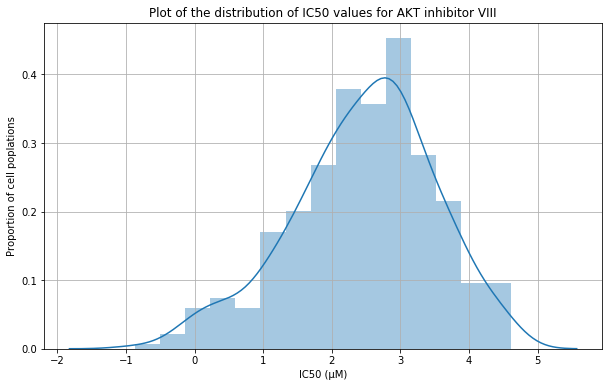

In [158]:
fig = plt.figure(figsize = (10,6))
sns.distplot(ML_matrix[[drug_name]])
plt.title("Plot of the distribution of IC50 values for "+ drug_name)
plt.xlabel("IC50 (µM)")
plt.ylabel("Proportion of cell poplations")
plt.grid(True);

### Categorization of Resistant vs. Sensitive 

Everything that's above the mean + 0.5 $\times$ the standard deviation (high IC50) is classified as "resistant" wheras eveything below the mean - 0.5 $\times$ the standard deviation is classified at "sensitive". Everything that is in the middle is discarded.

In [159]:
print("The lower threshold used here is the mean minus half the standard deviation = ", np.mean(ML_matrix[drug_name])-0.5*np.std(ML_matrix[drug_name]))
print("The upper threshold used here is the mean plus half the standard deviation = ", np.mean(ML_matrix[drug_name])+ 0.5*np.std(ML_matrix[drug_name]))
ML_matrix["Response"] = pd.cut(ML_matrix[drug_name], [np.min(ML_matrix[drug_name]), np.mean(ML_matrix[drug_name]) - 0.5*np.std(ML_matrix[drug_name]), np.mean(ML_matrix[drug_name]) + 0.5*np.std(ML_matrix[drug_name]), np.max(ML_matrix[drug_name])], labels = ["sensitive","medium", "resistant"])
ML_matrix = ML_matrix.drop([drug_name], axis = 1)
ML_matrix

The lower threshold used here is the mean minus half the standard deviation =  1.938177765111892
The upper threshold used here is the mean plus half the standard deviation =  2.9754186983027435


,PLCH2_mut,UBE4B_mut,ADGRB2_mut,ZSCAN20_mut,SZT2_mut,MOB3C_mut,ZFYVE9_mut,ST6GALNAC3_mut,TCHH_mut,HRNR_mut,...,DMTF1_del,PPP4R1_del,CDH1_del,SLC12A6_del,PTBP3_del,KCNE2_del,DGCR2_del,CASP8AP2_del,SCO2_del,Response
22RV1_PROSTATE,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
A204_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
A253_SALIVARY_GLAND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium
A673_BONE,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,sensitive
CORL23_LUNG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium
DOV13_OVARY,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,resistant
G401_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
G402_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,medium


In [160]:
#Drop all the "medium" classes
ML_matrix = ML_matrix.drop(ML_matrix[ML_matrix["Response"] == "medium"].index)
ML_matrix = ML_matrix.dropna()
ML_matrix.head()

,PLCH2_mut,UBE4B_mut,ADGRB2_mut,ZSCAN20_mut,SZT2_mut,MOB3C_mut,ZFYVE9_mut,ST6GALNAC3_mut,TCHH_mut,HRNR_mut,...,DMTF1_del,PPP4R1_del,CDH1_del,SLC12A6_del,PTBP3_del,KCNE2_del,DGCR2_del,CASP8AP2_del,SCO2_del,Response
22RV1_PROSTATE,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
A204_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,sensitive
DOV13_OVARY,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,resistant
G401_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sensitive


In [161]:
# Looking at class balance
print("Number of resistant cells: ", len(ML_matrix[ML_matrix["Response"] == "resistant"]))
print("Number of sensitive cells: ", len(ML_matrix[ML_matrix["Response"] == "sensitive"]))
print("Total number of cells: ", len(ML_matrix.index))

Number of resistant cells:  115
Number of sensitive cells:  103
Total number of cells:  218


We see that our classes are more or less equal (which is good!). 

### Feature Selection Using PCA

Number of features before PCA:  64144


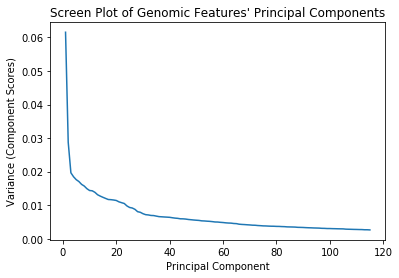

Number of combined features after PCA:  115


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114
0,14.853387,-1.572214,-0.520516,-1.348829,-2.544276,-2.859470,0.574764,-2.354666,3.510730,3.379274,...,0.134767,-0.083641,-0.069306,0.025596,0.085416,0.110379,-0.166596,0.228699,-0.046695,0.249908
1,-2.780231,-2.566008,-0.566927,0.281171,-0.041544,0.477274,-0.767875,-0.389608,-0.014405,0.161379,...,0.039789,0.396288,0.517266,-0.854342,0.221160,0.063672,0.075186,-0.455338,0.043098,0.189863
2,-3.274776,-2.082376,-0.532471,0.195440,-0.445788,0.239348,-0.269201,-0.547192,0.262184,-0.580693,...,-0.978619,-0.386949,-0.516694,0.309793,0.652019,0.120134,0.658797,-0.020877,-0.412934,0.511817
3,5.478775,-1.899268,-1.093572,0.001509,-0.253411,-0.451717,-1.017878,-0.258292,0.635176,0.571479,...,-0.446930,0.007528,-0.313587,-0.621405,-0.124125,0.261736,0.041279,0.005926,0.017361,0.136338
4,-3.153342,-2.671736,-0.612688,0.400755,-0.363671,0.402008,-0.692085,-0.186999,-0.238061,0.409314,...,-0.111546,0.011984,-0.053957,-0.027569,-0.196867,-0.353371,0.069048,-0.051429,-0.187297,0.052284


In [169]:
from sklearn.decomposition import PCA

X = ML_matrix.drop("Response", axis = 1)
y = ML_matrix["Response"].astype(str)

NB_COMPONENTS = 115
screeplot = True
kf = 5

print("Number of features before PCA: ", len(ML_matrix.columns) - 1)


my_PCA = PCA(n_components=NB_COMPONENTS)
reduced_X = pd.DataFrame(my_PCA.fit_transform(np.array(X.values), y=None))
reduced_X.columns = [f"PC{elem}" for elem in range(NB_COMPONENTS)]

if screeplot:
    fig = plt.figure()
    g = sns.lineplot(x = range(1,NB_COMPONENTS+1), y = my_PCA.explained_variance_ratio_)
    plt.xlabel('Principal Component')
    plt.ylabel('Variance (Component Scores)')
    plt.title('Screen Plot of Genomic Features\' Principal Components')
    plt.show(); 


print("Number of combined features after PCA: ",len(list(reduced_X)))
reduced_X.head()

### Fitting to PCA-Selected Data: Random Forest

In [170]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

np.random.seed(0)

#Scaling the features -- useful for most classifier except RF and co        
feature_names = list(reduced_X) #stores the name of features
sc = StandardScaler()  #defines the scaler
reduced_X = pd.DataFrame(sc.fit_transform(reduced_X)) #scales the data
reduced_X.columns = feature_names 

random_forest = RandomForestClassifier(n_estimators=300, max_depth = 3, max_leaf_nodes = 10)

random_forest_scores = cross_val_score(random_forest,reduced_X,y,cv=kf) # fit + predict + eval. (uses all data)
print('Random Forest Average Accuracy:', str(round(random_forest_scores.mean()*100,3)),'%')
print('SD:', 100*np.std(random_forest_scores))

Random Forest Average Accuracy: 55.0 %
SD: 8.03226868169534


### Fitting to PCA-Selected Data: SVM

In [171]:
from sklearn.svm import SVC

np.random.seed(0)

svm = SVC()
svm_scores = cross_val_score(svm,reduced_X,y,cv=kf)  # fit + predict + eval.
print('SVM Average Accuracy:', str(round(svm_scores.mean()*100,3)),'%')
print('SD:', 100*np.std(svm_scores))

SVM Average Accuracy: 54.144 %
SD: 2.5846908922670826


### Fitting to PCA-Selected Data: Logistic Regression

In [172]:
from sklearn.linear_model import LogisticRegression

np.random.seed(0)

logreg = LogisticRegression(solver= 'saga', max_iter=5000) #instantiate                            
logreg_scores = cross_val_score(logreg,reduced_X,y,cv=kf)  # fit + predict + eval.
print('Logistic Regression Average Accuracy:', str(round(logreg_scores.mean()*100,3)),'%')
print('SD:', 100*np.std(logreg_scores))

Logistic Regression Average Accuracy: 51.427 %
SD: 7.229083857584291


### Fitting to PCA-Selected Data: K-Nearest Neighbors

In [173]:
from sklearn.neighbors import KNeighborsClassifier

np.random.seed(0)

knn = KNeighborsClassifier(n_neighbors = 5)            # instantiate               
knn_scores = cross_val_score(knn,reduced_X,y,cv=kf)    # fit + predict + eval.
print('KNN Average Accuracy:', str(round(knn_scores.mean()*100,3)),'%')
print('SD:', 100*np.std(knn_scores))

KNN Average Accuracy: 50.497 %
SD: 7.621307904300006


### Fitting to PCA-Selected Data: MultiLayer Perceptron

In [174]:
from sklearn.neural_network import MLPClassifier

np.random.seed(0)

mlp = MLPClassifier(max_iter=5000)                   # instantiate                                  
mlp_scores = cross_val_score(mlp,reduced_X,y,cv=kf)  # fit + predict + eval. 
print('Perceptron Average Accuracy:', str(round(mlp_scores.mean()*100,3)),'%')
print('SD:', 100*np.std(mlp_scores))

Perceptron Average Accuracy: 50.095 %
SD: 10.353927013596827


### Evaluation of Machine Learning Models with PCA-Selected Data

In [175]:
#displays dataframe with cross-validation scores from each machine learning model

d = {'Machine Learning Model':['SVM','Logistic Regression', 'KNN', 'MLP'], \
        'Average Accuracy (Percent)': [np.round(np.mean(svm_scores*100)),np.round(np.mean(logreg_scores*100)),np.round(np.mean(knn_scores*100)), np.round(np.mean(mlp_scores*100)) \
                                    ]}
print()
print(f'Baseline: {100*np.round(len(ML_matrix[ML_matrix["Response"] == "resistant"])/len(ML_matrix.index),2)}%')
print()
print('Results Using 5-Fold Cross Validation:')
display(pd.DataFrame(data=d))


Baseline: 53.0%

Results Using 5-Fold Cross Validation:


,Machine Learning Model,Average Accuracy (Percent)
0,SVM,54.0
1,Logistic Regression,51.0
2,KNN,50.0
3,MLP,50.0


##  Alternative Feature Selection Methods

We're going to try a different method of feature selection, then re-fit the data to each of the models. Prior to this, we will also make a preliminary feature reduction were all the features with a variance lower than 0.1 will be discarded. Without this preliminary feature selection, none of the model below performs better than the baseline, and some of them cannot even be run due to computational constraints.

In [176]:
# removing the features with a variance of less than 0.1
variance = ML_matrix.var(axis = 0)
reduced_ML_matrix = ML_matrix.loc[:,variance[variance > 0.1].index]
reduced_ML_matrix["Response"] = [0 if x=='resistant' else 1 for x in ML_matrix['Response']]
reduced_ML_matrix.head()

,TCHH_mut,HRNR_mut,FLG2_mut,BAZ2B_mut,SCN9A_mut,CRYBG3_mut,ANK2_mut,RP1L1_mut,MPDZ_mut,ABCA2_mut,...,SERPINB12_del,SERPINB11_del,SEC11C_del,CTDP1_del,DSEL_del,SOCS6_del,TXNL1_del,VPS4B_del,ZNF516_del,Response
22RV1_PROSTATE,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A204_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
DOV13_OVARY,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
G401_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [116]:
def scale_data(X_train, X_test):
    
    feature_names = list(X_train) # Store the feature names
    
    sc = StandardScaler()  # Defines the scaler
    X_train = pd.DataFrame(sc.fit_transform(X_train))  # Scales the training data
    X_test = pd.DataFrame(sc.transform(X_test))  # Scales the validation data

    # Replace feature names in the database (they are lost during scaling)
    X_train.columns = feature_names
    X_test.columns = feature_names
    
    return X_train, X_test

In [117]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel 
from sklearn.model_selection import ShuffleSplit

from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFE

def run_model(X, y, clf, FS = "None", n_splits = 5):
    
    train_accuracies, val_accuracies, rocs = [],[],[]

    # Define a cross-validation (shuffleSplit here)
    ss = ShuffleSplit(n_splits, test_size=0.2, random_state=0)

    for count, (training_indices, val_indices) in enumerate(ss.split(X, y), 1):

        print(f'Cross-validation: {count}/{n_splits}')

        # Prepare the test and training set     
        X_train = X.iloc[training_indices,:]#.sample(frac=1, random_state = 6)
        y_train = y.iloc[training_indices]#.sample(frac=1, random_state = 6)
        X_val = X.iloc[val_indices,:]#.sample(frac=1, random_state = 6)
        y_val = y.iloc[val_indices]#.sample(frac=1, random_state = 6)
        print(f"The validation set corresponds to roughly {np.round(100*(len(X_val.index)/len(X.index)),2)}% of the total data.") 
        
        #Scaling the features -- useful for most classifier except RF and co
        X_train, X_val = scale_data(X_train, X_val)
        
        if FS == "RFE":
            selector = RFE(estimator = LinearSVC())
            X_train = pd.DataFrame(selector.fit_transform(X_train, y_train))
            X_val = pd.DataFrame(selector.transform(X_val))
        elif FS == "LASSO":
            X_train, X_val = lasso_feature_reduction(X_train, X_val, y_train)
        elif FS == "RF":
            X_train, X_val, impor = rf_feature_reduction(X_train, X_val, y_train)
        elif FS == "None":
            pass
        else:
            print("Check your feature selection method. Enter either 'RFE', LASSO', 'RF' or 'None'.")
            return
        
        # Fit the classifier
        clf.fit(X_train.values.tolist(), y_train.values)        
        
        # Predict the classes
        y_pred = clf.predict(X_val.values.tolist())
        
        # Calculate the performance metrics 
        train_acc = accuracy_score(y_train.values.tolist(), clf.predict(X_train.values.tolist()))
        val_acc = accuracy_score(y_val.values.tolist(), y_pred)
        #roc_auc = roc_auc_score(y_val.values, clf.predict_proba(X_val.values)[:, 1])
        
        print(f"Training accuracy {count}: {train_acc}")
        print(f"Validation accuracy {count}: {val_acc}")
        #print(f"ROC AUC {count}: {roc_auc}")
    
        # Add the performances to their corresponding lists
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        #rocs.append(roc_auc)
    print("_________________________________________________________________________________")   
    print(f'Average Training Accuracy of {model_names[i]} {np.round(100*np.mean(train_accuracies), 2)} +/- {np.round(100*np.std(train_accuracies),2)}%.')
    print(f'Average Validation Accuracy of {model_names[i]} {np.round(100*np.mean(val_accuracies),2)} +/- {np.round(100*np.std(val_accuracies),2)}%.')
    #print(f'Average area under the curve {np.round(100*np.mean(np.array(rocs)),2)} +/- {np.round(100*np.std(np.array(rocs)),2)}%.')
    
    return 100*np.mean(train_accuracies), 100*np.std(train_accuracies), 100*np.mean(val_accuracies), 100*np.std(val_accuracies)#, 100*np.mean(np.array(rocs)), 100*np.std(np.array(rocs))


In [118]:
N_SPLITS = 5
X = reduced_ML_matrix.drop("Response", axis = 1)
y = reduced_ML_matrix["Response"].astype('float64')

models = [svm, logreg, mlp, random_forest]
model_names = ['SVM','Logistic Regression','MLP', 'Random Forest']

final_results = pd.DataFrame(columns = {"SVM", "Logistic Regression", "MLP", "Random Forest"})

### Recursive Feature Elimination

In [119]:
for i in range(len(models)):
    print('Running',model_names[i])
    print('______________________\n')
    perf = run_model(X, y, models[i], FS = "RFE", n_splits = N_SPLITS)
    final_results.loc["RFE Feature Selection",model_names[i]] = perf[2]
    print()

Running SVM
______________________

Cross-validation: 1/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 1: 1.0
Validation accuracy 1: 0.5909090909090909
Cross-validation: 2/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 2: 0.9942528735632183
Validation accuracy 2: 0.5909090909090909
Cross-validation: 3/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 3: 0.9942528735632183
Validation accuracy 3: 0.6136363636363636
Cross-validation: 4/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 4: 0.9942528735632183
Validation accuracy 4: 0.5909090909090909
Cross-validation: 5/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 5: 0.9942528735632183
Validation accuracy 5: 0.5909090909090909
_________________________________________________________________________________
Average Training Accuracy of SVM 99.5

### Lasso Feature Reduction

In [120]:
def lasso_feature_reduction(X_train, X_val, y_train, Cst = 0.01):
    
    clf = LinearSVC(C = Cst, penalty = "l1", dual = False) #SVC(kernel = 'linear', C = Cst)
    clf.fit(X_train.values, y_train)
    
    model = SelectFromModel(clf, prefit=True, threshold=-np.inf, max_features = 300)
    new_X_train = model.transform(X_train.values)
    new_X_val = model.transform(X_val.values)
    
    return pd.DataFrame(new_X_train), pd.DataFrame(new_X_val)


for i in range(len(models)):
    print('Running',model_names[i])
    print('______________________\n')
    perf = run_model(X, y, models[i], FS = "LASSO", n_splits = N_SPLITS)
    final_results.loc["Lasso Feature Selection",model_names[i]] = perf[2]
    print()

Running SVM
______________________

Cross-validation: 1/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 1: 0.9885057471264368
Validation accuracy 1: 0.5909090909090909
Cross-validation: 2/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 2: 1.0
Validation accuracy 2: 0.5681818181818182
Cross-validation: 3/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 3: 0.9942528735632183
Validation accuracy 3: 0.6136363636363636
Cross-validation: 4/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 4: 0.9942528735632183
Validation accuracy 4: 0.5454545454545454
Cross-validation: 5/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 5: 0.9712643678160919
Validation accuracy 5: 0.4772727272727273
_________________________________________________________________________________
Average Training Accuracy of SVM 98.9

### Random Forest Feature Reduction

In [121]:
def rf_feature_reduction(X_train, X_val, y_train, N_ESTIMATORS = 500):
    
    clf = RandomForestClassifier(n_estimators = N_ESTIMATORS, n_jobs = -1, class_weight = "balanced", random_state = 32)
    clf = clf.fit(X_train.values, y_train.values)
    
    model = SelectFromModel(clf, prefit=True, threshold=-np.inf, max_features = 300)   
    new_X_train = model.transform(X_train)
    new_X_val = model.transform(X_val)
    
    importances = clf.feature_importances_
    #std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0) --> std dev but we don't use it anyway
    
    return pd.DataFrame(new_X_train), pd.DataFrame(new_X_val), importances

for i in range(len(models)):
    print('Running',model_names[i])
    print('______________________\n')
    perf = run_model(X, y, models[i], FS = "RF", n_splits = N_SPLITS)
    final_results.loc["Random Forest Feature Selection",model_names[i]] = perf[2]    
    print()

Running SVM
______________________

Cross-validation: 1/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 1: 0.9942528735632183
Validation accuracy 1: 0.75
Cross-validation: 2/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 2: 0.9827586206896551
Validation accuracy 2: 0.5681818181818182
Cross-validation: 3/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 3: 0.9885057471264368
Validation accuracy 3: 0.6136363636363636
Cross-validation: 4/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 4: 0.9942528735632183
Validation accuracy 4: 0.5454545454545454
Cross-validation: 5/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 5: 0.9942528735632183
Validation accuracy 5: 0.5681818181818182
_________________________________________________________________________________
Average Training Accuracy of SVM 99.

### No Feature Selection

In [123]:
for i in range(len(models)):
    print('Running',model_names[i])
    print('______________________\n')
    perf = run_model(X, y, models[i], FS = "None", n_splits = N_SPLITS)
    final_results.loc["No Feature Selection",model_names[i]] = perf[2]
    print()

Running SVM
______________________

Cross-validation: 1/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 1: 0.9770114942528736
Validation accuracy 1: 0.7272727272727273
Cross-validation: 2/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 2: 0.9712643678160919
Validation accuracy 2: 0.6363636363636364
Cross-validation: 3/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 3: 0.9712643678160919
Validation accuracy 3: 0.5909090909090909
Cross-validation: 4/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 4: 0.9770114942528736
Validation accuracy 4: 0.6136363636363636
Cross-validation: 5/5
The validation set corresponds to roughly 20.18% of the total data.
Training accuracy 5: 0.9942528735632183
Validation accuracy 5: 0.5909090909090909
_________________________________________________________________________________
Average Training Accur

In [128]:
display(final_results)

,Logistic Regression,Random Forest,MLP,SVM
RFE Feature Selection,56.3636,55,61.3636,59.5455
Lasso Feature Selection,59.5455,56.3636,56.8182,55.9091
Random Forest Feature Selection,59.5455,56.3636,63.1818,60.9091
No Feature Selection,60.4545,56.8182,61.3636,63.1818


### Major Takeaways

 - None of the methods of feature selection have lead to satisfying results. Alternative solutions have to be investigated.

### Next Steps

- The GDSC portal provides a list of 659 features that are frequently altered in cancer and are correlated with drug sensitivity. We will use these to add different weights to features.
- We will experiment with Pearson's coefficient, Spearman's correlation and Elastic Net in feature selection.